In [1]:
import numpy as np
import matplotlib.pylab as plt
import quadprog as QP
import mpl_toolkits.mplot3d.axes3d as p3
import matplotlib.animation as ani
import matplotlib as mpl
from cvxpy import *

In [2]:
def hat_map(x):   
    return np.array([[0,-x[2],x[1]],[x[2],0,-x[0]],[-x[1],x[0],0]])

In [3]:
def position_dynamics(tau,x,xdot,v):
    return(xdot)

In [65]:
def velocity_dynamics(tau,x,xdot,v):    
    return(v)

In [120]:
def reference(tau):
    w = 0.2
    d = np.pi/12
    ref_theta = 5*np.pi/9+d*np.sin(w*tau)
    ref_phi = 0.2*tau
    return(np.array([np.sin(ref_theta)*np.cos(ref_phi),np.sin(ref_theta)*np.sin(ref_phi),np.cos(ref_theta)]))

In [121]:
def reference_velocity(tau):
    w = 0.2
    d = np.pi/12
    ref_theta = 5*np.pi/9+d*np.sin(w*tau)
    ref_phi = 0.2*tau
    v1 = np.array([-0.2*np.sin(ref_theta)*np.sin(ref_phi),0.2*np.sin(ref_theta)*np.cos(ref_phi),0])
    v2 = np.array([w*np.cos(ref_theta)*np.cos(ref_phi)*np.cos(w*tau)*d,w*np.cos(ref_theta)*np.sin(ref_phi)*np.cos(w*tau)*d,-w*np.sin(ref_theta)*np.cos(w*tau)*d])
    return(v1+v2)

In [122]:
def reference_acceleration(tau):
    w = 0.2
    d = np.pi/12
    ref_theta = 5*np.pi/9+d*np.sin(w*tau)
    ref_phi = 0.2*tau
    a1 = np.array([-0.2**2*np.sin(ref_theta)*np.cos(ref_phi),-0.2**2*np.sin(ref_theta)*np.sin(ref_phi),0])
    a2 = np.array([-0.2*w*np.cos(ref_theta)*np.sin(ref_phi)*np.cos(w*tau)*d,0.2*w*np.cos(ref_theta)*np.cos(ref_phi)*np.cos(w*tau)*d,0])
    a3 = np.array([-0.2*w*np.cos(ref_theta)*np.sin(ref_phi)*np.cos(w*tau)*d,0.2*w*np.cos(ref_theta)*np.cos(ref_phi)*np.cos(w*tau)*d,0])
    a4 = np.array([-np.sin(ref_theta)*np.cos(ref_phi)*(w*np.cos(w*tau)*d)**2,-np.sin(ref_theta)*np.sin(ref_phi)*((w*np.cos(w*tau)*d)**2),-np.cos(ref_theta)*(w*np.cos(w*tau)*d)**2])
    a5 = np.array([-w**2*np.cos(ref_theta)*np.cos(ref_phi)*np.sin(w*tau)*d,-w**2*np.cos(ref_theta)*np.sin(ref_phi)*np.sin(w*tau)*d,w**2*np.sin(ref_theta)*np.sin(w*tau)*d])
    return(a1+a2+a3+a4)

In [8]:
def safety_center(tau,invariant):
    if invariant == 1:
        return(np.array([0,0,-1]))
    else:
        ref_theta = 4*np.pi/5
        ref_phi = 0.25*tau
        return(np.array([np.sin(ref_theta)*np.cos(ref_phi),np.sin(ref_theta)*np.sin(ref_phi),np.cos(ref_theta)]))

In [9]:
def safety_center_velocity(tau,invariant):  
    if invariant == 1:
        return(np.array([0,0,0]))
    else:
        ref_theta = 4*np.pi/5
        ref_phi = 0.25*tau
        return(np.array([-0.25*np.sin(ref_theta)*np.sin(ref_phi),0.25*np.sin(ref_theta)*np.cos(ref_phi),0]))

In [10]:
def safety_center_acceleration(tau,invariant):  
    if invariant == 1:
        return(np.array([0,0,0]))
    else:
        ref_theta = 4*np.pi/5
        ref_phi = 0.25*tau
        return(np.array([-0.25**2*np.sin(ref_theta)*np.cos(ref_phi),-0.25**2*np.sin(ref_theta)*np.sin(ref_phi),0]))

In [11]:
def position_error(tau,x):    
    return(np.dot(hat_map(x)**2,reference(tau)))

In [12]:
def velocity_error(tau,x,xdot):    
    return(xdot-np.cross(np.cross(reference(tau),reference_velocity(tau)),x))

In [212]:
def safety_constraints(tau,x,invariant,i):
    if i == 0:
        g = np.cos(np.pi/12)-1+np.inner(x,safety_center(tau,invariant))
    else:
        if i == 1:
            g = -(np.cos(np.pi/3)-1+np.inner(x,safety_center(tau,invariant)))
    return(g)

In [82]:
def CLF(tau,x,xdot):
    V1 = 0.5*np.dot(velocity_error(tau,x,xdot),velocity_error(tau,x,xdot))
    V2 = 0.5*alpha*(1-np.dot(x,reference(tau)))
    V3 = epsilon*np.dot(position_error(tau,x),velocity_error(tau,x,xdot))
    return(V1+V2+V3)

In [15]:
def h_function(tau,x,xdot,i,invariant):
    return(gamma[i]*safety_constraints(tau,x,invariant,i) + 
          ((-1)**i)*(np.inner(safety_center(tau,invariant),xdot)+np.inner(safety_center_velocity(tau,invariant),x)))

In [16]:
def feedforward_control_law(tau,x,xdot):
    u1 = -np.cross(np.cross(reference(tau),reference_acceleration(tau)),x)    
    u2 = np.dot(hat_map(x)**2,np.cross((np.cross(reference(tau),reference_velocity(tau))),xdot).T).T    
    return(u1+u2)

In [17]:
def phi_0(tau,x,i,invariant):    
    return(((-1)**i)*safety_center(tau,invariant))    

In [18]:
def phi_1(tau,x,xdot,i,invariant):    
    p1 = gamma[i]*(h_function(tau,x,xdot,i,invariant)-gamma[i]*safety_constraints(tau,x,invariant,i))
    p2 = (-1)**i*(2*np.inner(xdot,safety_center_velocity(tau,invariant))+
                    np.inner(x,safety_center_acceleration(tau,invariant)))
    return(p1+p2)

In [19]:
def psi_0(tau,x,xdot):
    psi0 = velocity_error(tau,x,xdot) + epsilon*position_error(tau,x)
    return(psi0)    

In [20]:
def psi_1(tau,x,xdot):
    p11 = np.cross(np.cross(reference(tau),reference_acceleration(tau)),x)
    p12 = np.cross((np.cross(reference(tau),reference_velocity(tau))),xdot)
    P1 = -np.inner(psi_0(tau,x,xdot),p11+p12)
    P2 = -0.5*alpha*(np.inner(xdot,reference(tau))+np.inner(x,reference_velocity(tau)))
    p31 = np.cross(xdot,(np.cross(x,reference(tau))))
    p32 = np.cross(x,(np.cross(xdot,reference(tau))+np.cross(x,reference_velocity(tau))))
    P3 = np.inner(epsilon*velocity_error(tau,x,xdot),p31+p32)    
    return(P1+P2+P3)

In [21]:
def second_order_rk4_step(tau,x0,xdot0,v):    
    h = tau[1]-tau[0]
    print()
    k11 = h*position_dynamics(tau[0],x0,xdot0,v)
    k12 = h*velocity_dynamics(tau[0],x0,xdot0,v)
    k21 = h*position_dynamics(tau[0]+h/2,x0+k11/2,xdot0+k12/2,v)
    k22 = h*velocity_dynamics(tau[0]+h/2,x0+k11/2,xdot0+k12/2,v)
    k31 = h*position_dynamics(tau[0]+h/2,x0+k21/2,xdot0+k22/2,v)
    k32 = h*velocity_dynamics(tau[0]+h/2,x0+k21/2,xdot0+k22/2,v)
    k41 = h*position_dynamics(tau[0]+h,x0+k31,xdot0+k32,v)
    k42 = h*velocity_dynamics(tau[0]+h,x0+k31,xdot0+k32,v)
    x = x0 + (k11+2*k21+2*k31+k41)/6   
    x = x/np.linalg.norm(x)
    xdot = xdot0 + (k12+2*k22+2*k32+k42)/6
    xdot = xdot - np.inner(x,xdot)*x
    return(x,xdot)

In [22]:
def leap_frog_step(tau,x0,xdot0,v):    
    dt = tau[1]-tau[0]
    if tau[0] == 0:
        x = x0 + dt*xdot0
        xdot = xdot0 + dt*velocity_dynamics(tau,x0,xdot0,v)
    else:
        x = x0 + 2*dt*xdot0
        xdot = xdot0 + 2*dt*velocity_dynamics(tau,x0,xdot0,v)
    x = x/np.linalg.norm(x)
    xdot = xdot - np.inner(x,xdot)*x
    return(x,xdot)

In [23]:
def euler_step(tau,x0,xdot0,v):    
    dt = tau[1]-tau[0]    
    x = x0 + dt*xdot0
    xdot = xdot0 + dt*velocity_dynamics(tau,x0,xdot0,v) 
    x = x/np.linalg.norm(x)
    xdot = xdot - np.inner(x,xdot)*x
    return(x,xdot)

In [213]:
def geometric_control_law_2(tau,x,xdot,invariant):
    u_ff = feedforward_control_law(tau,x,xdot)
    v = Variable(3)
    delta = Variable(1)    
    constraints = [psi_0(tau,x,xdot)*v + np.inner(psi_0(tau,x,xdot),u_ff)+psi_1(tau,x,xdot)+eta*CLF(tau,x,xdot) <= delta,
                  x*v  + np.inner(x,u_ff) == 0]
    hard_constraints = [-(phi_0(tau,x,0,invariant)*v + np.dot(phi_0(tau,x,0,invariant),u_ff)+phi_1(tau,x,xdot,0,invariant)+
                     mu[0]*(h_function(tau,x,xdot,0,invariant))**3) <= 0,
                     -(phi_0(tau,x,1,invariant)*v + np.dot(phi_0(tau,x,1,invariant),u_ff)+phi_1(tau,x,xdot,1,invariant)+
                     mu[1]*(h_function(tau,x,xdot,1,invariant))**3) <= 0]
    constraints.extend(hard_constraints)
    prob = Problem(objective, constraints)
    result = prob.solve(solver=ECOS_BB)        
    return(v.value)

In [25]:
def geometric_control_law(tau,x,xdot,invariant):
    G = np.concatenate((np.concatenate((H,np.zeros([3,1])),axis=1),np.array([np.array([0,0,0,Lambda])])),axis=0)
    a = np.zeros([4,])     
    c0 = np.concatenate((np.array([x]).T,np.zeros([1,1])),axis=0)
    c1 = np.concatenate((np.array([-psi_0(tau,x,xdot)]).T,np.ones([1,1])),axis=0)    
    c2 = np.concatenate((np.array([phi_0(tau,x,0,invariant)]).T,np.zeros([1,1])),axis=0)
    c3 = np.concatenate((np.array([phi_0(tau,x,1,invariant)]).T,np.zeros([1,1])),axis=0)
    C = np.concatenate((c0,c1,c2,c3),axis=1)
    u_ff = feedforward_control_law(tau,x,xdot)
    b0 = -np.inner(x,u_ff)
    b1 = np.inner(psi_0(tau,x,xdot),u_ff)+psi_1(tau,x,xdot)+eta*CLF(tau,x,xdot)    
    b2 = -(np.inner(phi_0(tau,x,0,invariant),u_ff)+phi_1(tau,x,xdot,0,invariant)+mu[0]*(h_function(tau,x,xdot,0,invariant))**3)
    b3 = -(np.inner(phi_0(tau,x,1,invariant),u_ff)+phi_1(tau,x,xdot,1,invariant)+mu[1]*(h_function(tau,x,xdot,1,invariant))**3)
    b = np.array([np.asscalar(b0),np.asscalar(b1),np.asscalar(b2),np.asscalar(b3)])    
    v,f,vu,iterations,lagrangian,iact = QP.solve_qp(G,a,C,b,1)
    v = np.array(v[0:3])
    return(v)

In [270]:
t0 = 0
tmax = 60
n_points = np.round(tmax-t0)*30
alpha = 1
epsilon = 0.05
gamma = 10*[1,1]

H = 6*np.array([[1, 0, 0],[0, 1, 0],[0,0,1]])
Lambda = 20
eta = 50
mu = [5,5]
invariance = 0

In [271]:
theta0 = 1.45 
phi0 = 0
q0 = np.array([np.sin(theta0)*np.cos(phi0),np.sin(theta0)*np.sin(phi0),np.cos(theta0)])
q0 = q0/np.linalg.norm(q0)
qdot0 = np.array([0,0,0])

In [272]:
t = np.linspace(t0,tmax,n_points)
q = np.zeros([t.shape[0],3])
qdot = np.zeros([t.shape[0],3])
qd = np.zeros([t.shape[0],3])
qd_dot = np.zeros([t.shape[0],3])
g0 = np.zeros([t.shape[0],1])
g1 = np.zeros([t.shape[0],1])
gd0 = np.zeros([t.shape[0],1])
gd1 = np.zeros([t.shape[0],1])
h0 = np.zeros([t.shape[0],1])
h1 = np.zeros([t.shape[0],1])
V = np.zeros([t.shape[0],1])
q[0,:] = q0
qdot[0,:] = qdot0
qd[0,:] = reference(t[0])
qd_dot[0,:] = reference_velocity(t[0])
V[0] = CLF(0,q0,qdot0)
g0[0] = safety_constraints(0,q0,invariance,0)
g1[0] = safety_constraints(0,q0,invariance,1)
gd0[0] = safety_constraints(0,qd[0],invariance,0)
gd1[0] = safety_constraints(0,qd[0],invariance,1)
h0[0] = h_function(0,q0,qdot0,0,invariance)
h1[0] = h_function(0,q0,qdot0,1,invariance)

In [273]:
for i in range(1,t.size):
    u_ff = feedforward_control_law(t[i-1],q[i-1,:],qdot[i-1,:])
    u_fb = geometric_control_law_2(t[i-1],q[i-1,:],qdot[i-1,:],invariance).T
    u = u_ff+u_fb    
    q[i,:],qdot[i,:] = euler_step(t[i-1:i+1],q[i-1,:],qdot[i-1,:],u)    
    qd[i,:] = reference(t[i])
    qd_dot[i,:] = reference_velocity(t[i])    
    V[i] = CLF(t[i],q[i,:],qdot[i,:])
    g0[i] = safety_constraints(t[i],q[i,:],invariance,0)
    g1[i] = safety_constraints(t[i],q[i,:],invariance,1)
    gd0[i] = safety_constraints(t[i],qd[i,:],invariance,0)
    gd1[i] = safety_constraints(t[i],qd[i,:],invariance,1)
    h0[i] = h_function(t[i],q[i,:],qdot[i,:],0,invariance)
    h1[i] = h_function(t[i],q[i,:],qdot[i,:],1,invariance)

In [279]:
np.savetxt("q_var.txt",q)
np.savetxt("qd_var.txt",qd)
np.savetxt("g0_var.txt",g0)
np.savetxt("g1_var.txt",g1)
np.savetxt("gd0_var.txt",gd0)
np.savetxt("gd1_var.txt",gd1)
np.savetxt("V_var.txt",V)
np.savetxt("t_var.txt",t)

In [175]:
fig = plt.figure()
ax = p3.Axes3D(fig)
ax.plot3D(q[:,0], q[:,1], q[:,2])
ax.plot3D(qd[:,0], qd[:,1], qd[:,2])
ax.set_autoscalez_on(False)
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
ax.set_zlim3d(bottom=-1, top=1)
ax.set_aspect('equal')
plt.savefig("second_trajectory1.pdf")
plt.close()

/usr/lib/python3/dist-packages/mpl_toolkits/mplot3d/axes3d.py:120: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  self.axesPatch.set_linewidth(0)
/usr/lib/python3/dist-packages/mpl_toolkits/mplot3d/axes3d.py:1528: MatplotlibDeprecationWarning: The is_scalar function was deprecated in version 2.1.
  if len(args[0]) == 0 or cbook.is_scalar(args[0][0]) :
/usr/lib/python3/dist-packages/mpl_toolkits/mplot3d/axes3d.py:247: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  self.axesPatch.draw(renderer)


In [277]:
width = 3.487
height = width / 1.618
f, arr = plt.subplots(figsize = (3*width, 3*height),nrows = 1, ncols=3)
for i in range(3):
    axq = arr[i]
    axq.plot(t, q[:,i],label = r"$q$")
    axq.plot(t, qd[:,i],label = r"$q_d$")
    axq.set_xlabel("Time[s]")
    axq.set_title(r"$q_{}$".format(i))
    axq.legend(loc = 'best')
f.tight_layout(rect=[0, 0.03, 1, 0.95])
f.savefig('m_invariant_time_plots.pdf')
plt.close()

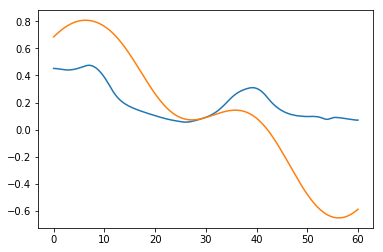

In [278]:
plt.plot(t,g0,t,gd0)
plt.show()
plt.close()